<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Long_Term_Analysis_of_Equities_and_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:09:49 Starting...
14:09:49 Installing yfinance into Google notebook...
14:09:54 Installing arch into Google notebook...
14:10:01 Initialized.


/tmp/ipython-input-2957036660.py:2: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  gold.index=pd.DatetimeIndex(gold.index).to_period('B')


,Close
,XAU
Date,
1968-04-01,37.70
1968-04-02,37.30
1968-04-03,37.60
1968-04-04,36.95
1968-04-05,37.00
...,...
2026-01-28,5306.95
2026-01-29,5405.00


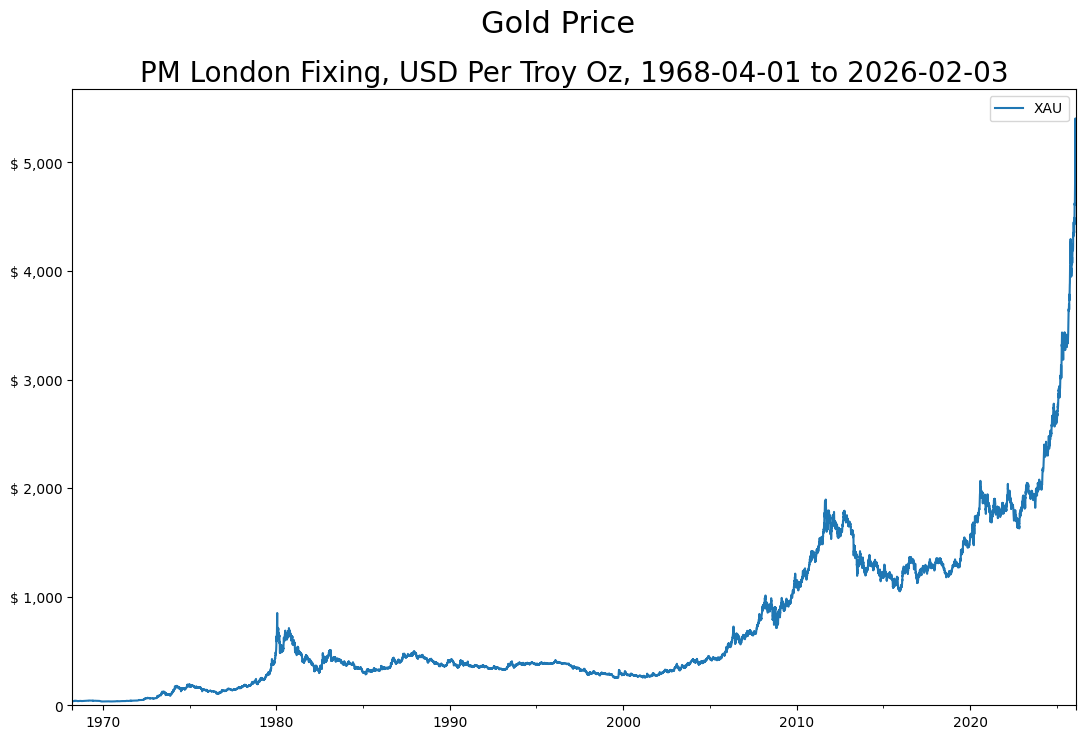

In [30]:
gold=pd.read_json("https://prices.lbma.org.uk/json/gold_pm.json")[["d","v"]].set_index("d")
gold.index=pd.DatetimeIndex(gold.index).to_period('B')
gold.index.name='Date'
gold[('Close',alternative:='XAU')]=gold['v'].apply(lambda x:x[0])
gold.drop('v',axis=1,inplace=True)
gold.columns=pd.MultiIndex.from_tuples(gold.columns)
display(gold)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
gold['Close'].plot(ax=plot)
figure.suptitle(title:='Gold Price (XAU/USD)',fontsize=22)
plot.set_title(subtitle:='PM London Fixing, USD Per Troy Oz, %s to %s' % (gold.index[0],gold.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

/tmp/ipython-input-54619090.py:8: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  bills.index=bills.index.to_timestamp().to_period('B')


,Discount Rate,Days,Return,Close
,DTB3,,,DTB3
Date,,,,
1954-01-04,1.33,0,NaN,1000.000000
1954-01-05,1.28,1,0.003694,1000.036944
1954-01-06,1.28,2,0.003556,1000.072501
1954-01-07,1.31,3,0.003556,1000.108059
1954-01-08,1.31,4,0.003639,1000.144452
...,...,...,...,...
2026-01-27,3.58,26321,0.009972,21480.699757
2026-01-28,3.59,26322,0.009944,21482.835894


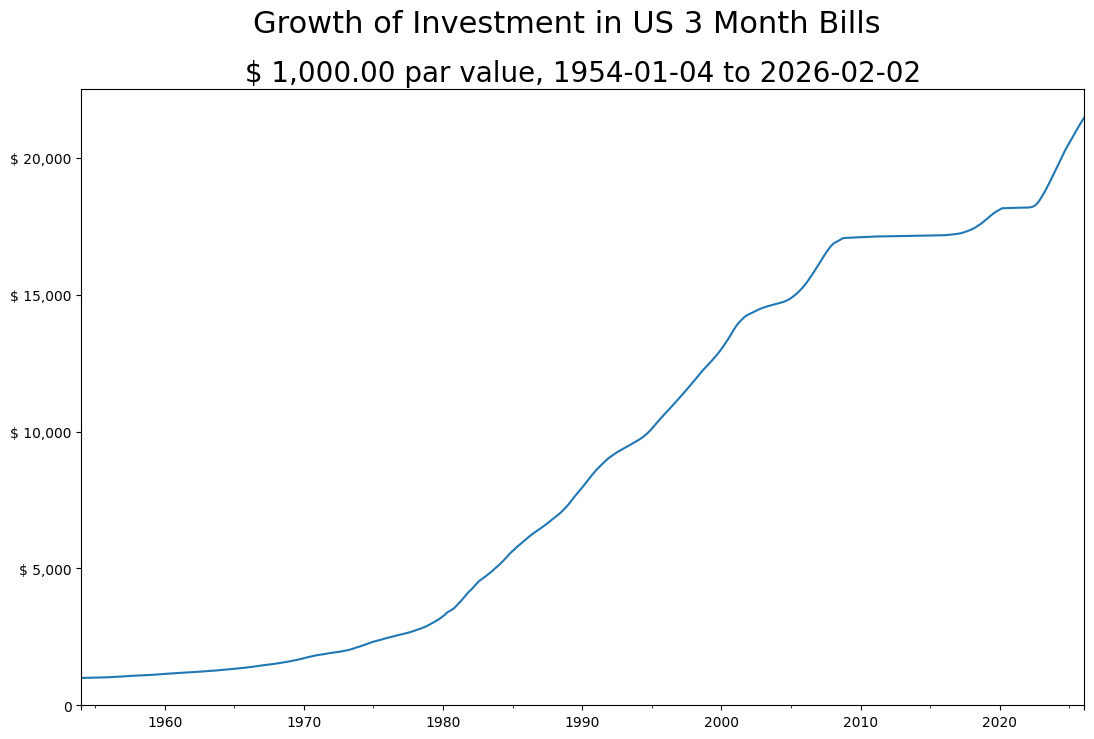

In [116]:
bills=get_fred(n:='DTB3')[0]
bills.index.name='Date'
bills.columns=pd.MultiIndex.from_tuples([('Discount Rate',n)])
bills['Days']=list(map(lambda x:(x-bills.index[0]).n,bills.index))
bills['Return']=bills[('Discount Rate',n)].shift()/360e0*bills['Days'].diff()
bills[('Close',n)]=(par:=1e3)*(one+bills['Return']/hundred).cumprod()
bills.loc[bills.index[0],('Close',n)]=par
bills.index=bills.index.to_timestamp().to_period('B')
display(bills)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
bills[('Close',n)].plot(ax=plot)
figure.suptitle(title:='Growth of Investment in US 3 Month Bills',fontsize=22)
plot.set_title(subtitle:='$ {:,.2f} par value, {:s} to {:s}'.format(par,str(bills.index[0]),str(bills.index[-1])),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2805495238.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.DatetimeIndex(data.index).to_period('B')
/tmp/ipython-input-2805495238.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred


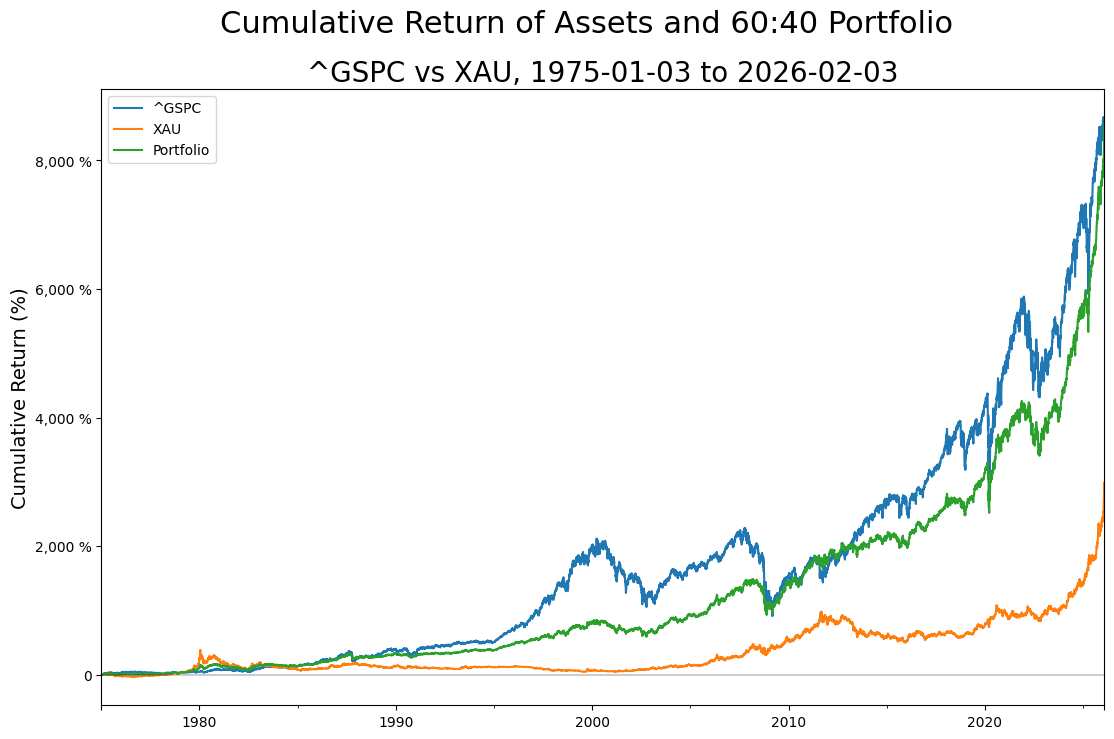

In [126]:
data=download(market:='^GSPC',"1975-01-01",today("%Y-%m-%d"),auto_adjust=True)
tickers=[market,alternative:='XAU']
data.index=pd.DatetimeIndex(data.index).to_period('B')
data[('Close',alternative)]=gold[('Close',alternative)] if alternative=='XAU' else bills[('Close',alternative)]
data.columns=pd.MultiIndex.from_tuples(data.columns)
#data=data.resample('M').last()

for ticker in tickers:
    data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred
    data[('Weight',ticker)]=0.6 if ticker==market else 0.4

data.dropna(inplace=True)
data.sort_index(axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

for ticker in tickers+['Portfolio']:
    data[('Cumulative',ticker)]=(data[('Return',ticker)]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and 60:40 Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [127]:
from warnings import filterwarnings ; filterwarnings('ignore',category=pd.errors.PerformanceWarning)

report=pd.DataFrame({'Weight':np.arange(zero,one+(delta:=0.05),delta)}).set_index("Weight")

if data.index.dtype==pd.PeriodDtype('W'):
    annualize=52e0

elif data.index.dtype==pd.PeriodDtype('M'):
    annualize=12e0

elif data.index.dtype==pd.PeriodDtype('Q'):
    annualize=4e0

elif data.index.dtype==pd.PeriodDtype('Y'):
    annualize=1e0

else:
    annualize=252e0

for weight in tqdm(report.index):
    report.loc[weight,market]=weight
    report.loc[weight,alternative]=one-weight

    for ticker in tickers:
        data[('Weight',ticker)]=report.loc[weight,ticker]

    data.drop(('Return','Portfolio'),axis=1,inplace=True)
    data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

    report.loc[weight,'Sample']=(r:=data[('Return','Portfolio')]).count()
    report.loc[weight,'Mean']=(m:=r.mean())
    report.loc[weight,'Std.Dev.']=(s:=r.std())
    report.loc[weight,'Std.Err.']=r.sem()
    report.loc[weight,'Kurtosis']=r.kurt()+three

report['Sharpe']=report['Mean']/report['Std.Dev.']*annualize**half
report['Sharpe S.E.']=((annualize/report['Sample'])*(one+(report['Kurtosis']-one)/four*report['Sharpe']**two))**half
report['Annualized']=hundred*(one+report['Mean']/hundred)**annualize-hundred

display(report)

  0%|          | 0/21 [00:00<?, ?it/s]

,^GSPC,XAU,Sample,Mean,Std.Dev.,Std.Err.,Kurtosis,Sharpe,Sharpe S.E.,Annualized
Weight,,,,,,,,,,
0.00,0.00,1.00,12561.0,0.033856,1.208090,0.010779,13.918803,0.444875,0.181345,8.904699
0.05,0.05,0.95,12561.0,0.034243,1.148540,0.010248,13.921489,0.473292,0.185955,9.010950
0.10,0.10,0.90,12561.0,0.034630,1.091890,0.009742,13.862426,0.503475,0.190827,9.117304
0.15,0.15,0.85,12561.0,0.035017,1.038614,0.009267,13.723964,0.535218,0.195814,9.223762
0.20,0.20,0.80,12561.0,0.035405,0.989257,0.008827,13.492958,0.568133,0.200716,9.330323
0.25,0.25,0.75,12561.0,0.035792,0.944434,0.008427,13.168809,0.601603,0.205308,9.436987
0.30,0.30,0.70,12561.0,0.036179,0.904820,0.008073,12.774615,0.634733,0.209416,9.543755
0.35,0.35,0.65,12561.0,0.036566,0.871125,0.007773,12.368744,0.666339,0.213025,9.650627
0.40,0.40,0.60,12561.0,0.036953,0.844058,0.007531,12.050304,0.694987,0.216407,9.757603


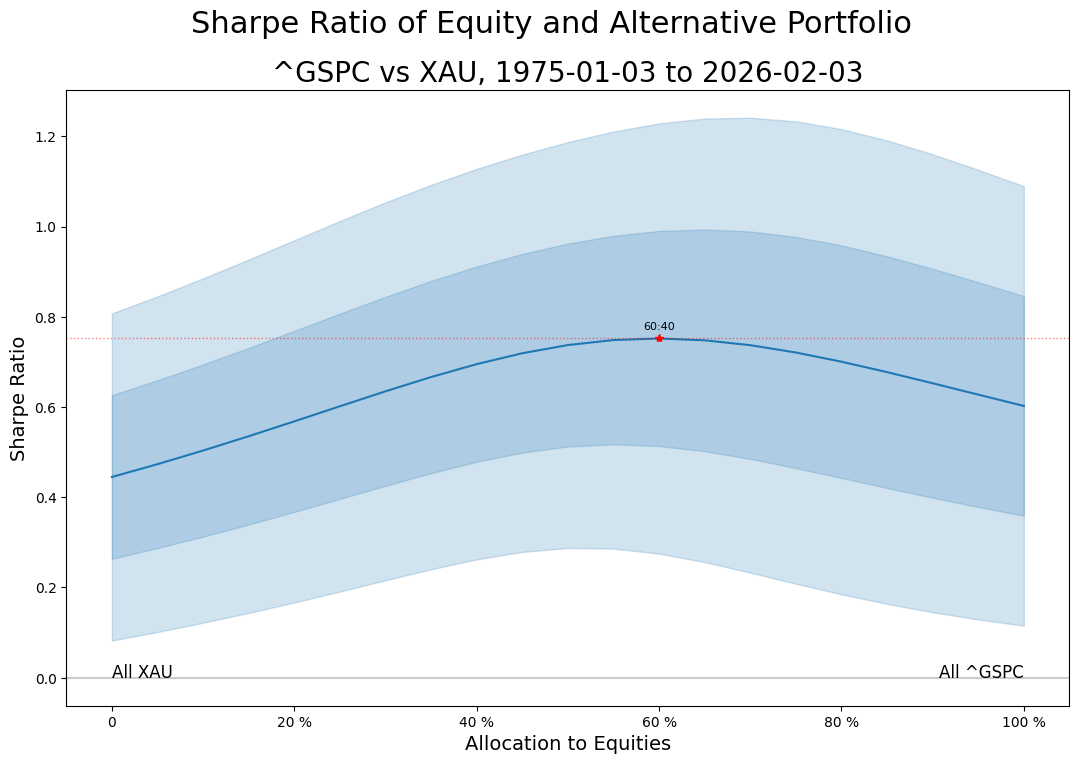

In [131]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index)*hundred,y:=report.loc[x,'Sharpe'])
plot.fill_between(x*hundred,y+(ye:=report.loc[x,'Sharpe S.E.']),y-ye,color='C0',alpha=0.2)
plot.fill_between(x*hundred,y+two*ye,y-two*ye,color='C0',alpha=0.2)
figure.suptitle(title:='Sharpe Ratio of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Sharpe Ratio',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[y.argmax()]*hundred,y.max(),'r*')
plot.text(x[y.argmax()]*hundred,y.max()*1.02,'%.0f:%.0f' % (x[y.argmax()]*hundred,hundred-x[y.argmax()]*hundred),fontsize=8,ha='center',va='bottom')
plot.axhline(y.max(),color='red',linestyle=':',linewidth=1,alpha=0.5)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

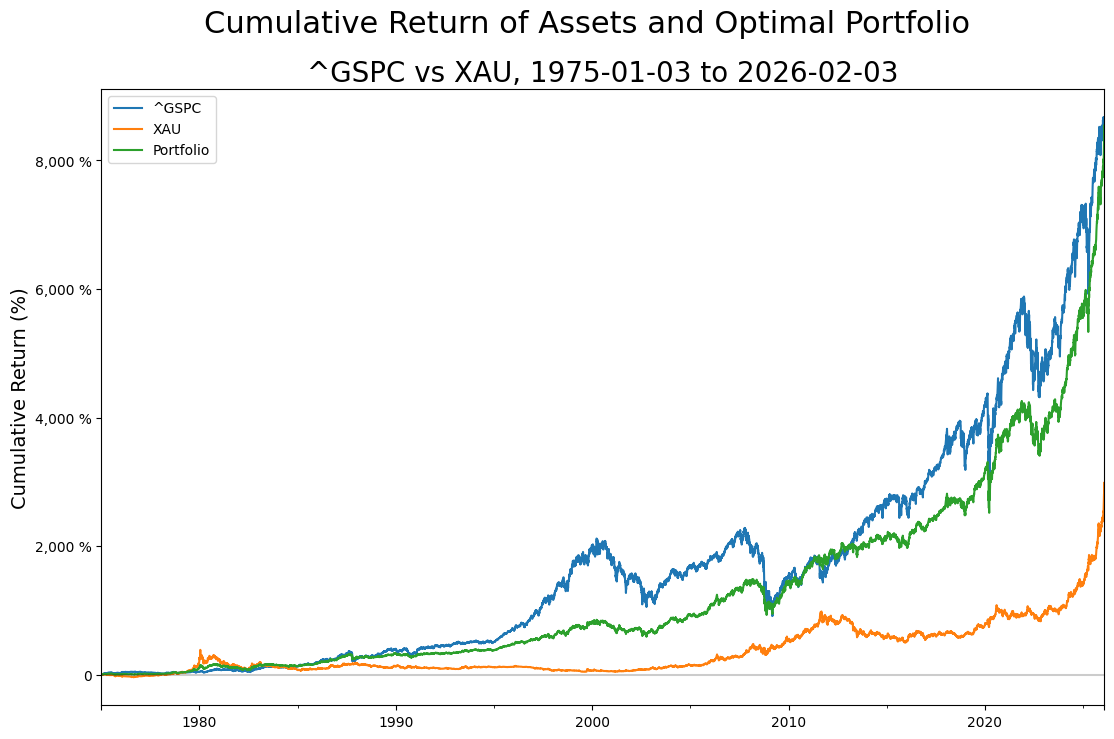

In [132]:
weight=x[y.argmax()]

for ticker in tickers:
    data[('Weight',ticker)]=report.loc[weight,ticker]

data.drop(('Return','Portfolio'),axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)
data[('Cumulative','Portfolio')]=(data[('Return','Portfolio')]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and Optimal Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [133]:
data

Close                      High          Low         Open  \
                XAU        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                      
1975-01-03   174.00    70.709999    71.639999    69.290001    70.230003   
1975-01-06   173.50    71.070000    72.239998    70.330002    70.709999   
1975-01-07   169.50    71.019997    71.750000    69.919998    71.070000   
1975-01-08   180.00    70.040001    71.529999    69.650002    71.019997   
1975-01-09   179.00    71.169998    71.419998    69.040001    70.040001   
...             ...          ...          ...          ...          ...   
2026-01-28  5306.95  6978.029785  7002.279785  6963.459961  7002.000000   
2026-01-29  5405.00  6969.009766  6992.839844  6870.799805  6977.740234   
2026-01-30  4981.85  6939.029785  6964.089844  6893.479980  6947.270020   
2026-02-02  4714.75  6976.439941  6991.919922  6914.339844  6916.640137   
2026-02-03  4920.95  6917.810059  6993.080078  6862.049805  6985.450195   

              Return                Volume Weight         Cumulative  \
                 XAU     ^GSPC       ^GSPC    XAU ^GSPC        ^GSPC   
Date                                                                   
1975-01-03 -0.571429  0.683462    15270000    0.4   0.6     0.683462   
1975-01-06 -0.287356  0.509123    17550000    0.4   0.6     1.196065   
1975-01-07 -2.305476 -0.070357    14890000    0.4   0.6     1.124866   
1975-01-08  6.194690 -1.379887    15600000    0.4   0.6    -0.270543   
1975-01-09 -0.555556  1.613360    16340000    0.4   0.6     1.338452   
...              ...       ...         ...    ...   ...          ...   
2026-01-28  4.792417 -0.008172  5507670000    0.4   0.6  8670.707520   
2026-01-29  1.847577 -0.129263  6877780000    0.4   0.6  8659.370229   
2026-01-30 -7.828862 -0.430190  6697340000    0.4   0.6  8621.688298   
2026-02-02 -5.361462  0.539127  5772050000    0.4   0.6  8668.709241   
2026-02-03  4.373509 -0.840398  7017660000    0.4   0.6  8595.017157   

                                        Return  
                    XAU    Portfolio Portfolio  
Date                                            
1975-01-03    -0.571429     0.181506  0.181506  
1975-01-06    -0.857143     0.372383  0.190531  
1975-01-07    -3.142857    -0.595613 -0.964405  
1975-01-08     2.857143     1.044504  1.649944  
1975-01-09     2.285714     1.798087  0.745794  
...                 ...          ...       ...  
2026-01-28  2932.542857  8492.365547  1.912064  
2026-01-29  2988.571429  8549.201727  0.661473  
2026-01-30  2746.771429  8256.023295 -3.389659  
2026-02-02  2594.142857  8103.851014 -1.821109  
2026-02-03  2711.971429  8206.002453  1.245164  

[12561 rows x 14 columns]